In [1]:
import matplotlib.pyplot as plt
import estimation_methods as est
import numpy as np

# Testing using synthetic systems

To compare our adaptive filters, we can generate synthetic systems that incorporate various types of perturbations and that feature varying levels of overdeterminedness. 

### Model setup

Consider an arbitrary multivariate signal and its measurement. We denote the system as:

$$\theta_{k+1}=f(x_k,u_k;\theta_k)+v_k$$

and the measurement as:

$$x_{k+1}=h(x_k,u_k;\theta_{k})+w_k$$

where $\theta_k\in\mathbb{R}^n$, $x_k\in\mathbb{R}^m$, $v_k\sim\mathcal{N}(0, Q)$, and $w_k\sim\mathcal{N}(0, R)$. (Note: We use $\theta$ and $x$ because we are interested in parameter estimation wherease for state estimation you might use $x$ in the system and $y$ in the measurement.)

Then, we linearize the measurement model with respect to previous parameters $\hat{\theta}_{k-1}$ using a first-order approximation:

$$x_{k+1}\approx f(x_k,u_k;\hat{\theta}_{k-1})+\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}(\theta_k-\hat{\theta}_{k-1})+w_k$$

Then, if we let

$$A_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}},\quad b_k=x_{k+1}-f(x_k,u_k;\hat{\theta}_{k-1})+A_k\hat{\theta}_{k-1}-w_k$$

we can rewrite the linearized measurement form as:

$$A_k\theta_k=b_k.$$


### Adaptive filters

For RLS and DEKA adaptive filters, we can directly estimate the paramters given an initial estimate, the Jacobian of the measurement with respect to the previous parameter estimate, and the actual measurement. For EKF, however, we must consider the noise covariance matrices and system Jacobian as well. As we do not know a priori what will occur to the system, we assume that the Jacobian of the system 

$$F_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}=I_n.$$

Similarly, we assume that both system and measurement noise is time invariant. Thus:

$$Q_k=c_1I_n,\quad R_k=c_2I_m$$

for some $c_1,c_2\in\mathbb{R}$. This reduces the predicted covariance update step in EKF to:

$$P_{k|k-1}=F_kP_{k-1|k-1}F_k^\mathsf{T}+Q_{k-1}=P_{k-1}+Q_{k-1}$$

For the remaining EKF steps, see the [Wikipedia page](https://en.wikipedia.org/wiki/Extended_Kalman_filter).


### Simulating on synthetic systems

We are interested in not only Gaussian noise but also arbitrary (sudden and gradual) scalings of the parameters. The latter case is of particular interest as we want to simulate how parameters may change in real-life scenarios like if a quadrotor were to pick up a large payload. Traditional adaptive filters should be able to handle these situations but they do not make use of particular inductive biases such as near-overdeterminedness of real-life systems.

To this end, we consider an arbitrary 13-state system with 2 parameters of interest.

In [2]:
d = 13 # state dimension
p = 2 # parameters

ekf = est.EKF(p, np.eye(p) * 0.005 ** 2, np.eye(d) * 0.005 ** 2)
rls = est.RLS(p, forgetting_factor=0.7)
arls = est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1)

theta_true = (np.random.rand(p, 1) - 1) * 20 # random parameters between in [-10, 10)
# theta_drift = (np.random.rand(p, 1) - 1) * 1  # slow parameter drift in [-0.5, 0.5)

filters = {'ekf': ekf, 'rls': rls, 'arls': arls}
estimates = {f: [[] for _ in range(p)] for f in filters.keys()}
actual = [[] for _ in range(p)]

n = 200

for k in range(n):
    A_k = np.random.randn(d, p)  # Random Jacobian
    b_k = A_k @ theta_true + np.random.randn(d, 1) * 0.1  # Noisy measurement

    for name, f in filters.items():
        estimate = f.update(A_k, b_k)

        for i in range(p):
            estimates[name][i].append(float(estimate[i]))

    for i in range(p):
        actual[i].append(float(theta_true[i]))

    # add perturbation
    if k % 25 == 0:
        theta_true *= np.random.uniform(0.25, 4, (p, 1))
    else:
        theta_true += np.random.normal(0, 0.005, (p, 1))

/tmp/ipykernel_12773/2489386497.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  estimates[name][i].append(float(estimate[i]))
/tmp/ipykernel_12773/2489386497.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual[i].append(float(theta_true[i]))


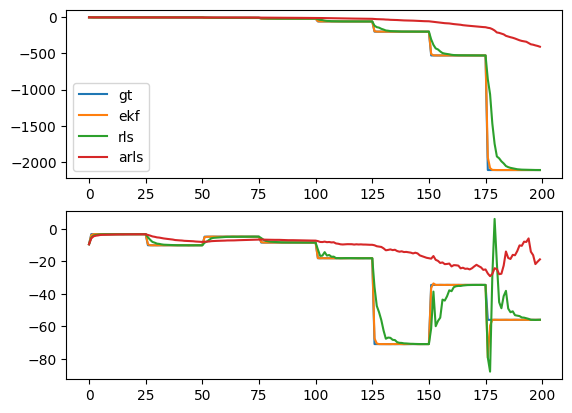

In [5]:
fig, axs = plt.subplots(p)
for i in range(p):
    axs[i].plot(actual[i], label='gt')

for name, vals in estimates.items(): 
    for i in range(p):
        axs[i].plot(vals[i], label=name)

axs[0].legend()
plt.show()